# 4 图像二值化的阈值变换

图像二值化的关键是 (最好能自动地) 选取合适的阈值. 选取阈值有如下方法.

### 迭代法

将像素的灰度值 $X$ 视为随机变量, 选取阈值 $T$ 使得 
$$T = \frac{1}{2}\big(\mathbb E(X|X< T) + \mathbb E(X|X\geqslant T)\big)$$
为此可以使用迭代法求解.

Threshold t = 135


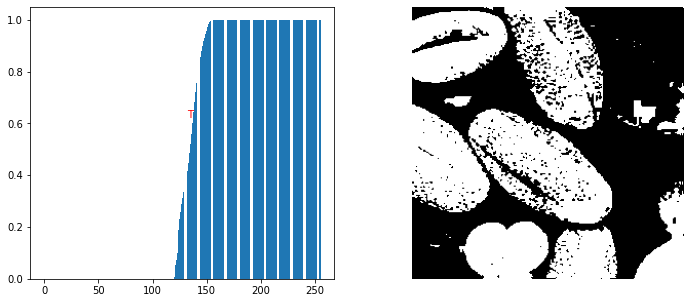

In [1]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
cdf = lambda x: np.array([np.sum(x <= i) for i in range(256)]) / x.size
def BasicGlobalThreshold(img, initial = None, verbose = True):
    c = cdf(img)
    e = np.cumsum(np.arange(256) * np.diff(c, prepend = 0)) # cummulative expectance
    t = initial or round(e[-1]) # initialize by the global expectance
    t2, ts = 300, [t]
    safe_ratio = lambda x, y: x/y if y != 0 else 0
    for _ in range(256): # iterate
        t2 = round(.5 * (safe_ratio(e[t],c[t]) + safe_ratio(e[-1]-e[t],1-c[t])))
        t2 = min(255, max(t2, 0))
        ts.append(t2)
        if t == t2: break 
        t = t2

    if verbose: print(ts)
    return t

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\cells.png')).convert('L'))
t = BasicGlobalThreshold(img, initial = None, verbose = False)
print('Threshold t = %d'%t)
img_bin = np.where(img > t, 1, 0)
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.bar(np.arange(256), cdf(img))
plt.text(t-3, cdf(img)[t]+.1, 'T', c='r')
plt.subplot(1,2,2)
plt.imshow(img_bin, cmap = 'gray')
plt.axis('off')
plt.show()

### OTSU 算法

亦称大津算法. 求解使得如下方差最大的 $T$ 作为阈值

$${\rm Var}=\mathbb P(X<T)\big(\mathbb E(X|X< T)-\mathbb E(X)\big)^2+\mathbb P(X\geqslant T)\big(\mathbb E(X|X\geqslant T)-\mathbb E(X)\big)^2
$$

使用拉格朗日恒等式, 此式可变形:

$$\begin{aligned}{\rm Var} &= {\rm Var}\cdot \left(\mathbb P(X<T)+\mathbb P(X\geqslant T)\right)
 \\ & =\left( \mathbb P(X<T)\big(\mathbb E(X|X< T)-\mathbb E(X)\big) + \mathbb P(X\geqslant T)\big(\mathbb E(X|X\geqslant T)-\mathbb E(X)\big)\right)^2

 \\ &\quad + \mathbb P(X<T)\mathbb P(X\geqslant T)\left( \big(\mathbb E(X|X< T)-\mathbb E(X)\big) - \big(\mathbb E(X|X\geqslant T)-\mathbb E(X)\big)\right)^2
 \\ &= \mathbb P(X<T)\mathbb P(X\geqslant T)\left( \mathbb E(X|X< T)- \mathbb E(X|X\geqslant T)\right)^2
 \end{aligned}
$$

Threshold t = 134


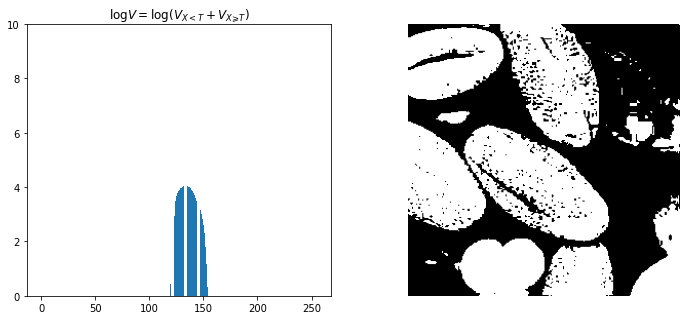

In [105]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
cdf = lambda x: np.array([np.sum(x <= i) for i in range(256)]) / x.size
def OTSU(img):
    c = cdf(img)
    e = np.cumsum(np.arange(256) * np.diff(c, prepend = 0)) # cummulative expectance
    c = np.clip(c, 1e-8, 1 - 1e-8) # avoid division by 0
    total_v = c * (1 - c) * np.square(e / c - (e[-1] - e) / (1 - c))
    total_v = np.square(e - c * e[-1]) / (c * (1 - c)) # same as the previous line
    total_v = np.log(total_v)
    return np.argmax(total_v), total_v 

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\cells.png')).convert('L'))
t, total_v = OTSU(img)
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.bar(np.arange(256), total_v)
plt.ylim(0, 10)
plt.title('$\\log V = \\log(V_{X< T}+V_{X\\geqslant T})$')
print('Threshold t = %d'%t)
img_bin = np.where(img > t, 1, 0)
plt.subplot(1,2,2)
plt.imshow(img_bin, cmap = 'gray')
plt.axis('off')
plt.show()

### 熵方法

选取阈值 $T$ 使得划分后如下两部分熵之和的最大:

$$\begin{aligned}H &= H_{X<T}+H_{X\geqslant T}
\\ &=-\int_{X<T}\frac{f(x)}{\mathbb P(X<T)}\log \frac{f(x)}{\mathbb P(X<T)}dx
-\int_{X\geqslant T}\frac{f(x)}{\mathbb P(X\geqslant T)}\log \frac{f(x)}{\mathbb P(X\geqslant T)}dx
\\ &= -\frac{\int_{X<T}f(x)\log f(x)dx}{\mathbb P(X<T)}-\frac{\int_{X\geqslant T}f(x)\log f(x)dx}{\mathbb P(X\geqslant T)}+\log \mathbb P(X<T)+\log \mathbb P(X\geqslant T)
\end{aligned}$$

Threshold t = 193


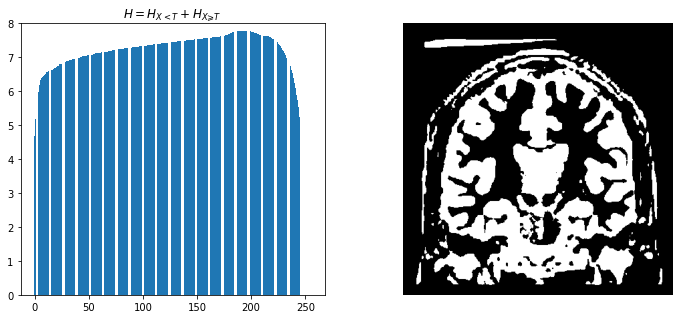

In [13]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
cdf = lambda x: np.array([np.sum(x <= i) for i in range(256)]) / x.size
def EntropyMethod(img):
    c = cdf(img)
    p = np.diff(c, prepend = 0)
    p = np.where(p == 0, 1, p) # avoid 0*log(0), instead use 1*log(1)
    h = np.cumsum(p * np.log(p)) # actually is (-1) * cummulative entropy
    c = np.clip(c, 1e-8, 1 - 1e-8)
    total_h = - h / c + np.log(c) - (h[-1] - h) / (1 - c)  + np.log(1 - c)
    return np.argmax(total_h), total_h 

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\brain.png')).convert('L'))
t, total_h = EntropyMethod(img)
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.bar(np.arange(256), total_h)
plt.ylim(0, 8)
plt.title('$H = H_{X< T}+H_{X\\geqslant T}$')
print('Threshold t = %d'%t)
img_bin = np.where(img > t, 1, 0)
plt.subplot(1,2,2)
plt.imshow(img_bin, cmap = 'gray')
plt.axis('off')
plt.show()

### 双阈值

有时候可以两个阈值. 介于阈值区间之间的为白, 阈值之外的部分为黑.

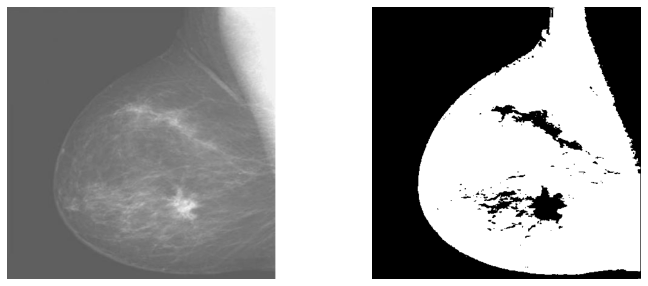

In [57]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\tissue.png')).convert('L'))
thresholds = (100, 150)
img2 = np.where(img > thresholds[1], 0, img)
img2 = np.where(img2 < thresholds[0], 0, 1)
plt.figure(figsize = (12, 5))
for i, _img_, vm in zip((1,2), (img, img2), (255, 1)):
    plt.subplot(1,2,i)
    plt.imshow(_img_, cmap = 'gray', vmin = 0, vmax = vm)
    plt.axis('off')
plt.show()